In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import ripser
import TDAvectorizer
from TDAvectorizer import computeNL, computeVAB, computeVPB, computePL, computePS, computeECC, computePES, computePI, DiagToPD, createEllipse

# Test TDAvectorizer package

In this file I am testing all functions from the TDAvectorizer package

## Separate functions

All the vectorization functions are realized as cython functions and are exported from `TDAvec.pyx` file. Let me show you how to use them and compare results with generated by R

Here is a point cloud that we will use:

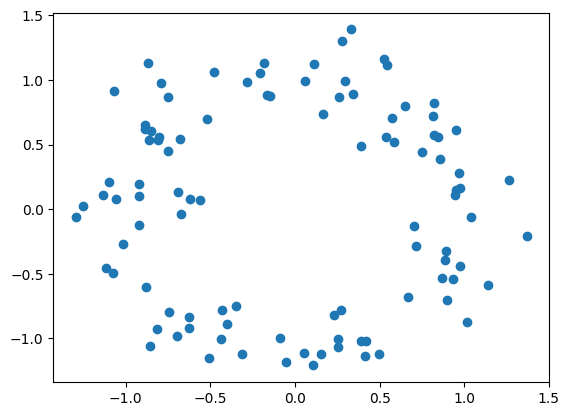

In [2]:
X = np.loadtxt("../R/unitCircle.csv", skiprows=1, delimiter=",")
plt.plot(X[:,0], X[:,1], "o")
plt.show()

I am going to use Ripser to create persistence diagrams.

In [3]:

D = ripser.ripser(X, thresh=2)["dgms"]
D[0][-1, 1] = 2


Let me try computeNL as an example

In [4]:
scaleSeq = np.linspace(0, 2, 11)
print("computeNL:")
for d in [0,1]:
    pyth = computeNL(D, d, scaleSeq)
    R = np.loadtxt("../R/nl_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computeNL:
	 dim=0: True
	 dim=1: True


As you can see, the results are equal to R. The same agreement holds for other vectorization functions

In [6]:
scaleSeq = np.linspace(0, 2, 11)
print("computePL:")
for d in [0,1]:
    pyth = computePL(D, d, scaleSeq)
    R = np.loadtxt("../R/pl_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computePL:
	 dim=0: True
	 dim=1: True


In [7]:
scaleSeq = np.linspace(0, 2, 11)
print("computePS:")
for d in [0,1]:
    pyth = computePS(D, d, scaleSeq)
    R = np.loadtxt("../R/ps_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computePS:
	 dim=0: True
	 dim=1: True


In [8]:
scaleSeq = np.linspace(0, 2, 11)
print("computeVAB:")
for d in [0,1]:
    pyth = computeVAB(D, d, scaleSeq)
    R = np.loadtxt("../R/vab_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computeVAB:
	 dim=0: True
	 dim=1: True


In [9]:
scaleSeq = np.linspace(0, 2, 11)
print("computeECC:")
for d in [0,1]:
    pyth = computeECC(D, d, scaleSeq)
    R = np.loadtxt("../R/ecc_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computeECC:
	 dim=0: True
	 dim=1: True


In [10]:
scaleSeq = np.linspace(0, 2, 11)
print("computePES:")
for d in [0,1]:
    pyth = computePES(D, d, scaleSeq)
    R = np.loadtxt("../R/pes_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computePES:
	 dim=0: True
	 dim=1: True


Here is how computeVPB works:

In [11]:
PD = DiagToPD(D)
ySeqH0 = np.quantile(PD[0][:,1], np.arange(0, 1.1, 0.2))
vpb0 = computeVPB(PD, homDim=0, xSeq = [], ySeq = ySeqH0)
print(np.allclose(
    vpb0, 
    np.loadtxt("../R/vpb_0.csv", skiprows=1)
    , atol=1e-7))


xSeqH1 = np.quantile(PD[1][:,0], np.arange(0, 1.1, 0.2))
ySeqH1 = np.quantile(PD[1][:,1], np.arange(0, 1.1, 0.2))

vpb1 = computeVPB(PD, homDim = 1, xSeq=xSeqH1, ySeq=ySeqH1)
vpb1 = np.transpose(vpb1).reshape( (25,))
print(np.allclose(
    vpb1, 
    np.loadtxt("../R/vpb_1.csv", skiprows=1)
    , atol=1e-7))


True
True


Here is computePI:

In [12]:
resB, resP = 5, 5
#
minPH0, maxPH0 = np.min(PD[0][:,1]), np.max(PD[0][:,1])
ySeqH0 = np.linspace(minPH0, maxPH0, resP+1)
xSeqH0 = np.zeros( resB+1)

minBH1, maxBH1 = np.min(PD[1][:,0]), np.max(PD[1][:,0])
xSeqH1 = np.linspace(minBH1, maxBH1, resB+1)
minPH1, maxPH1 = np.min(PD[1][:,1]), np.max(PD[1][:,1])
ySeqH1 = np.linspace(minPH1, maxPH1, resP+1)

sigma = 0.5*(maxPH0-minPH0)/resP
pi0 = computePI(PD, homDim = 0, xSeq = xSeqH0, ySeq = ySeqH0, sigma = sigma)
pi0_R = np.loadtxt("../R/pi_0.csv", skiprows=1)
print(0, np.allclose(pi0, pi0_R))

sigma = 0.5*(maxPH1-minPH1)/resP
pi1 = computePI(PD, homDim = 1, xSeq = xSeqH1, ySeq = ySeqH1, sigma = sigma)
pi1_R = np.loadtxt("../R/pi_1.csv", skiprows=1)
print(1, np.allclose(pi1, pi1_R))


0 True
1 True


## Class wrapper

As you can see, separate vectorization functions produce exactly the expected results, so they can easily used as they are. It could be a good idea to use a class wrapper to make them more user-friendly and follow usual python ideology. This can be done using the `TDAvectorizer` class.

In [13]:
vect = TDAvectorizer.TDAvectorizer()

Let me first create some points clouds:

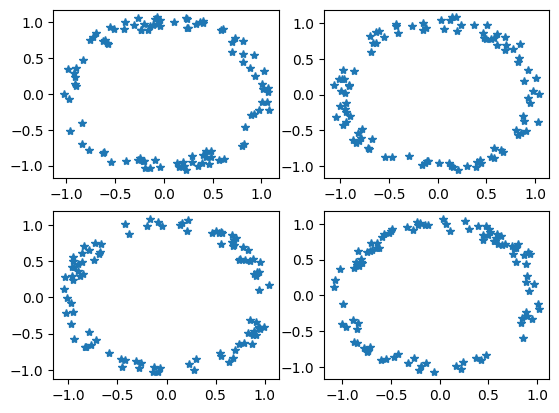

In [14]:

clouds = []
for i in range(4):
    clouds = clouds + [createEllipse()]
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax.plot( clouds[i][:,0], clouds[i][:,1], "*")

We can process these clouds using the `fit` method:

In [15]:
    
vect.fit(clouds)

As a result, we get a list of persistence diagrams will be created:

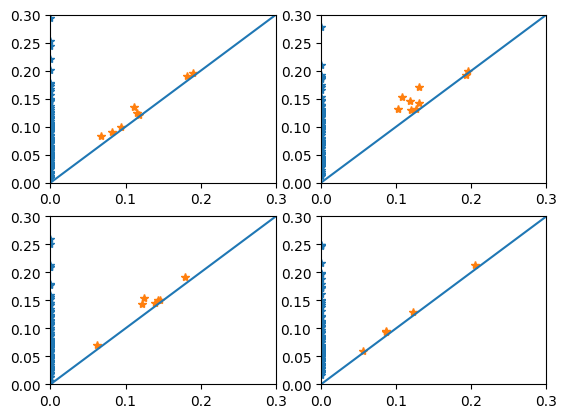

In [16]:
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax.plot( vect.diags[i][0][:,0], vect.diags[i][0][:,1], "*")
    ax.plot( vect.diags[i][1][:,0], vect.diags[i][1][:,1], "*")
    ax.set_ylim(0, 0.3)
    ax.set_xlim(0, 0.3)
    ax.axline( (0,0), slope=1)
plt.ticklabel_format()

Now we can transform these persistence diagrams into vector representation using the `transform` method.

Here, for example, you can see PL vectorization

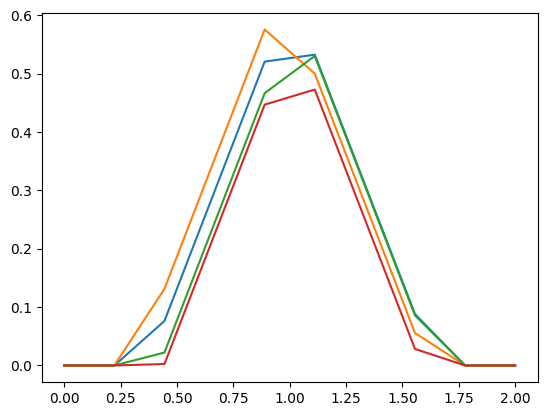

In [17]:
xSeq = np.linspace(0,2,10)
vvv = vect.transform(homDim = 1, output = "PL", xSeq = xSeq)
for v in vvv:
    plt.plot(xSeq, v)

With a simple change of parameters, you can consider the PS vectorization

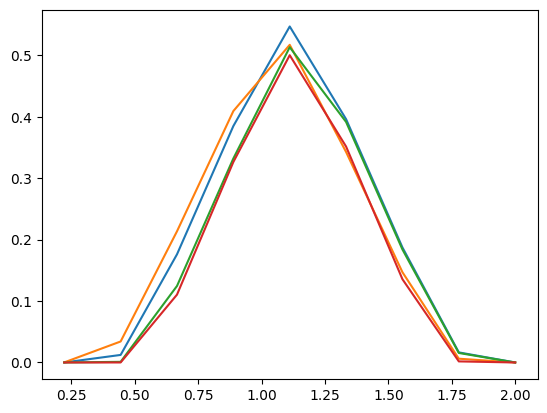

In [18]:
vvv = vect.transform(homDim = 1, output = "PS", xSeq = xSeq)
for v in vvv:
    plt.plot(xSeq[1:], v)

## Regression Example

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

Let us consider some more interesting example and try to use TDAvectorizer with some regression data

We will study ellipse with different ratio of the main axis:

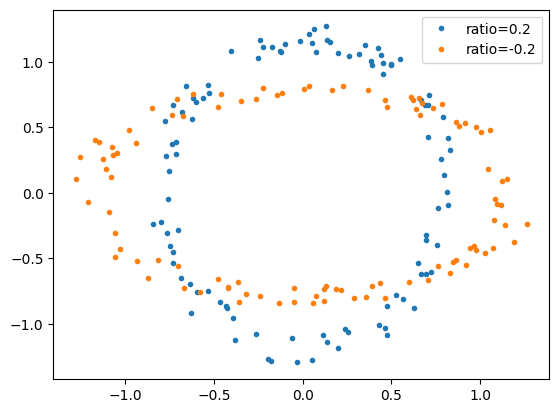

In [20]:
ratio = 0.2
X1 = createEllipse(a=1-ratio, b=1+ratio)
plt.plot(X1[:,0], X1[:,1], ".", label = "ratio=0.2")
ratio = -0.2
X2 = createEllipse(a=1-ratio, b=1+ratio)
plt.plot(X2[:,0], X2[:,1], ".", label="ratio=-0.2")
plt.legend()

In [21]:
clouds = []
ratList = np.random.uniform(-0.5, 0.5, 10**3)
for ratio in ratList:
    clouds = clouds + [createEllipse(a=1-ratio, b=1, eps=0.1)]
vect2 = TDAvectorizer.TDAvectorizer()
vect2.fit(clouds)

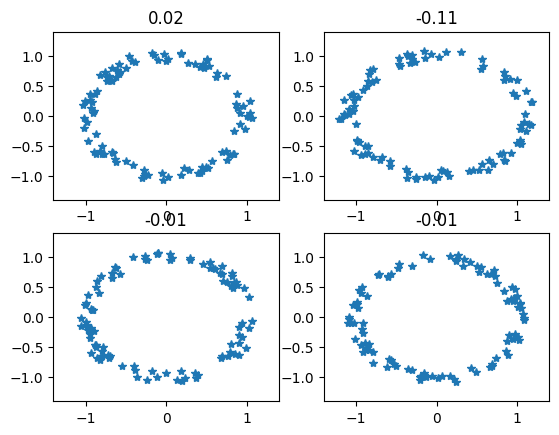

In [22]:
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax.plot( clouds[i][:,0], clouds[i][:,1], "*")
    ax.set_xlim(-1.4, 1.4)
    ax.set_ylim(-1.4, 1.4)
    ax.set_title( np.round(ratList[i], 2) )

Now we can compare performance of various extraction methods.

Let us first take a look at the true-prediction plots for single simulation

In [23]:
def computeScore(vect, y, method, homDim = 0, plot = False, Xseq = np.linspace(0,2,20), ax = None):
    X = vect.transform(homDim = homDim, output = method, xSeq=Xseq)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    reg = LinearRegression().fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    if plot:
        if ax is None:
            ax = plt.gca()
        predictions = reg.predict(X_test)
        ax.plot(predictions, y_test, ".")
        ax.axline( (0,0), slope=1)
        ax.set_title(f"{method}:, { round(score, 3)}")
    return score

In [24]:
methodList = ["vab", "pl", "ps", "nl", "ecc", "pes", "pi"]
len(methodList)

7

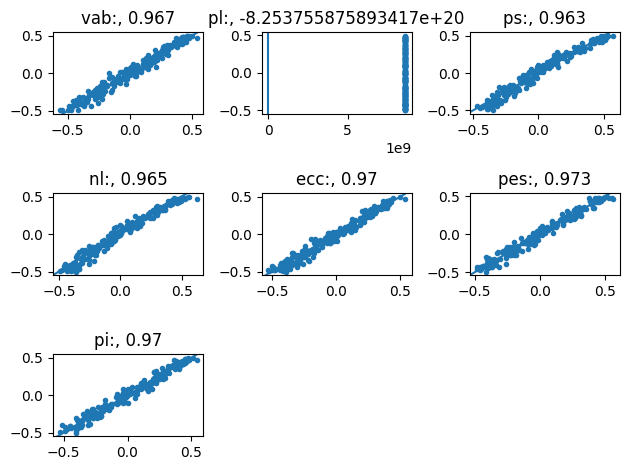

In [25]:
for i, method in enumerate(methodList):
    ax = plt.subplot(3, 3, i+1)
    computeScore(vect2, ratList, method, homDim = 0, plot = True, ax = ax)
plt.tight_layout()

Now I will collect more statistics about the performance score

In [88]:
df = pd.read_csv("./data/scores.csv")

In [91]:
from timeit import default_timer as timer

In [92]:
nSim = 10
totalTime = timer()
for iSim in range(nSim):
    start = timer()
    print(iSim+1, " / ", nSim, end = " ")
    print("|", end = "")
    ratList = np.random.uniform(-0.5, 0.5, 10**3)
    clouds = []
    for ratio in ratList:
        clouds = clouds + [createEllipse(a=1-ratio, b=1, eps=0.1)]
    vect2 = TDAvectorizer.TDAvectorizer()
    vect2.fit(clouds)

    print("*", end = "")
    for homDim in [0, 1]:
        for i, method in enumerate(methodList):
            score = computeScore(vect2, ratList, method, homDim = homDim, plot = False)
            df = pd.concat([df, pd.DataFrame({"method": [method], "homDim": [homDim], "score": score})])
            print(".", end = "")
    end = timer()
    print(f"| {round(end - start, 2)}")
totalEnd = timer()
print(f"Total time: {round(totalEnd - totalTime, 2)}")


1  /  10 |*..............| 30.0
2  /  10 |*..............| 29.87
3  /  10 |*..............| 29.91
4  /  10 |*..............| 29.99
5  /  10 |*..............| 29.97
6  /  10 |*..............| 30.01
7  /  10 |*..............| 29.94
8  /  10 |*..............| 29.92
9  /  10 |*..............| 30.16
10  /  10 |*..............| 30.56
Total time: 300.33


In [93]:
df.to_csv("./data/scores.csv", index=False)

In [61]:
import seaborn as sns

In [94]:
dfSumm = df.groupby(["method", "homDim"]).agg(mean = ("score", "mean"), std = ("score", "std"))
np.round(dfSumm.reset_index().query("abs(mean)<10"), 3)

,method,homDim,mean,std
0,ecc,0,0.970,0.005
1,ecc,1,0.988,0.014
3,nl,1,0.986,0.004
4,pes,0,0.973,0.004
5,pes,1,0.734,0.050
6,pi,0,0.970,0.009
9,pl,1,0.985,0.003
10,ps,0,0.966,0.004
11,ps,1,0.642,1.107
12,vab,0,0.972,0.004


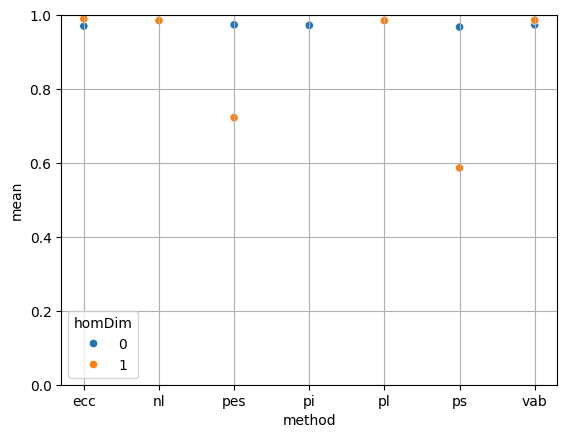

In [78]:
sns.scatterplot(
    data = dfSumm.reset_index().query("abs(mean)<10"), 
    x = "method", y = "mean", hue = "homDim")
plt.ylim(0,1)
plt.grid()

In [63]:
dfSumm

mean           std
method homDim                            
ecc    0       9.703797e-01  4.374076e-03
       1       9.899592e-01  6.530207e-03
nl     0      -5.772114e+16  1.914393e+17
       1       9.851352e-01  5.751948e-03
pes    0       9.738402e-01  4.530407e-03
       1       7.226011e-01  5.449739e-02
pi     0       9.722390e-01  5.481064e-03
       1      -1.070879e+04  3.546531e+04
pl     0      -3.589872e+21  3.971623e+21
       1       9.850625e-01  1.816988e-03
ps     0       9.677078e-01  4.525960e-03
       1       5.866069e-01  1.317563e+00
vab    0       9.738305e-01  3.386399e-03
       1       9.861594e-01  4.303166e-03

## Other

In [69]:
vvv.shape

(4, 9, 9)

In [35]:
vvv0 = vect.transform(homDim = 1, output = "PS", k=0)
vvv1 = vect.transform(homDim = 1, output = "PS", k=1)
vvv2 = vect.transform(homDim = 1, output = "PS", k=2)

PS
k =  0
PS
k =  1
PS
k =  2


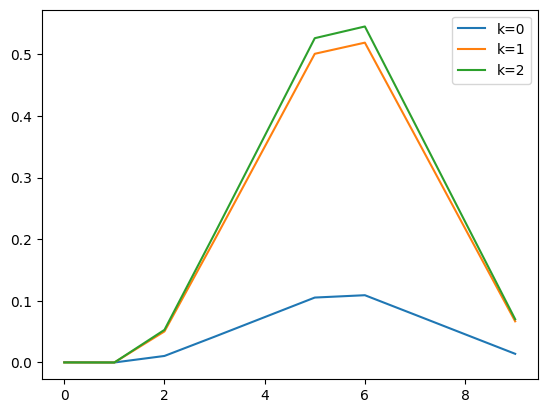

In [37]:
plt.plot(vvv0[0], label = "k=0")
plt.plot(vvv1[0], label = "k=1")
plt.plot(vvv2[0], label = "k=2")
plt.legend()

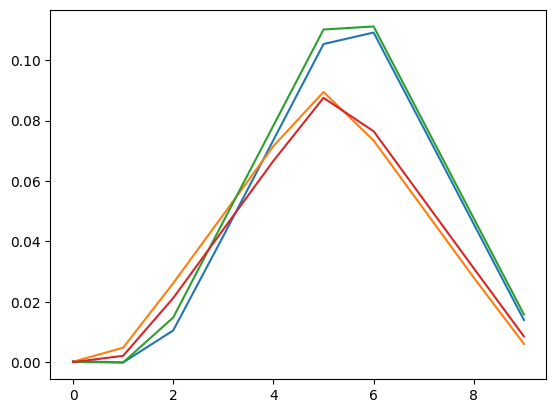

In [30]:
for v in vvv:
    plt.plot(v)

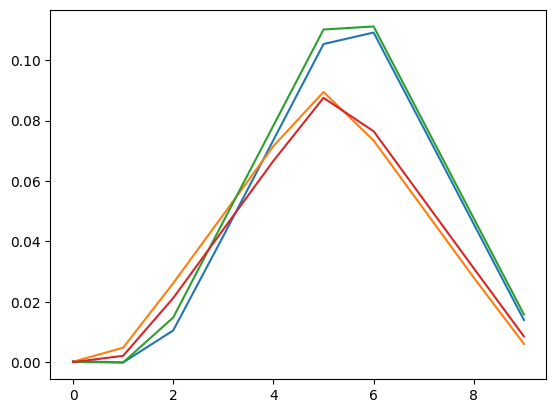

In [ ]:
for v in vvv:
    plt.plot(v)

In [7]:
vab

array([[0.38019654, 0.30433686, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.36996568, 0.84262842, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.60673255],
       [0.37160147, 0.48846091, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.91928861],
       [0.42698142, 0.23899696, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.89231297]])

In [107]:
vect.computeVAB(vect.diags[0], homDim = 1, scaleSeq = vect.params["scale"])

array([0.02263527, 0.54224413, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98358766])

In [98]:

vect.setParams({"output":"PL"})
assert vect.getParams("output") == "PL"

4

In [89]:
vect.findLimits(1)

{'minB': 0.04747302457690239,
 'maxB': 1.643264889717102,
 'minD': 0.049179304391145706,
 'maxD': 0.04747302457690239}

In [67]:
np.array([d[0][:,0] for d in vect.diags]).min()
np.array([d[0][:,0] for d in vect.diags]).max()

0.0

In [62]:
vect.findLimits(0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [54]:
len(vect.diags)

2

In [47]:
vect.diags[0][0][-1]

array([0., 2.])

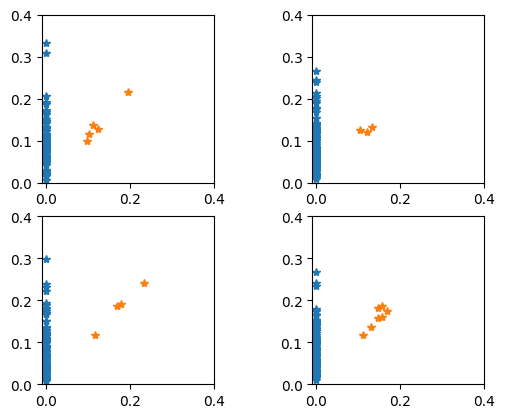

In [38]:
for i in range(len(vect.diags)):
    plt.subplot(2, 2, i+1)
    plt.plot( vect.diags[i][0][:,0], vect.diags[i][0][:,1], "*")
    plt.plot( vect.diags[i][1][:,0], vect.diags[i][1][:,1], "*")
    plt.xlim(-0.01, 0.4)
    plt.ylim(0, 0.4)
    plt.gca().set_aspect('equal', adjustable='box')